
## Sampling und Filterung des Korpus

Für die weitere Analyse konzentrieren wir uns auf den Zeitraum **1800–1900**.
Zudem möchten wir sicherstellen, dass jedes Jahrzehnt annähernd gleich stark vertreten ist.|

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
meta = pd.read_csv('../metadata/metadata_corpus-german_language_fiction.csv')
meta.head()

,lastname,firstname,title,year,volume,ID
0,Walloth,Wilhelm,Das Schatzhaus des Königs,1883,NaN,Wilhelm_Walloth_-_Das_Schatzhaus_des_Königs_(1...
1,Däubler,Theodor,L'Africana,1928,NaN,Theodor_Däubler_-_L'Africana_(1928)
2,Eyth,Max,Der Schneider von Ulm,1906,NaN,Max_Eyth_-_Der_Schneider_von_Ulm_(1906)
3,Novalis,NaN,Die Lehrlinge zu Sais,1799,NaN,Novalis_-_Die_Lehrlinge_zu_Sais_(1799)
4,Wieland,Christoph Martin,Agathodämon,1799,NaN,Christoph_Martin_Wieland_-_Agathodämon_(1799)


Filterung

In [17]:
subset = meta.query("1820 <= year < 1900")
subset.shape

(1331, 6)

In [18]:
# pro Jahrzehnt 50 Texte zufällig ziehen -- no 1 (random state = 42)
subset_decades = (
    subset.groupby(subset['year']//10*10)
    .apply(lambda x: x.sample(n=min(50, len(x)), random_state=42))
    .reset_index(drop=True)
)

In [19]:
subset_decades

,lastname,firstname,title,year,volume,ID
0,Baumann,Joseph,Ulli und Elsi,1829,NaN,Joseph_Baumann_-_Ulli_und_Elsi_(1829)
1,Hoffmann,ETA,Lebensansichten des Katers Murr,1820,NaN,ETA_Hoffmann_-_Lebensansichten_des_Katers_Murr...
2,Clauren,H.,Der selige Papier-Müller,1820,NaN,H._Clauren_-_Der_selige_Papier-Müller_(1820)
3,Hoffmann,ETA,Letzte Stücke,1822,NaN,ETA_Hoffmann_-_Letzte_Stücke_(1822)
4,Hauff,Wilhelm,Phantasien im Bremer Ratskeller,1827,NaN,Wilhelm_Hauff_-_Phantasien_im_Bremer_Ratskelle...
...,...,...,...,...,...,...
395,von Eschstruth,Nataly,Der Stern des Glücks,1896,NaN,Nataly_von_Eschstruth_-_Der_Stern_des_Glücks_(...
396,von Suttner,Bertha,Eva Siebeck,1892,NaN,Bertha_von_Suttner_-_Eva_Siebeck_(1892)
397,Heer,Jakob Christoph,An heiligen Wassern,1898,NaN,Jakob_Christoph_Heer_-_An_heiligen_Wassern_(1898)
398,Stinde,Julius,Die Seerose,1895,NaN,Julius_Stinde_-_Die_Seerose_(1895)


In [20]:
# Anzahl der Texte pro Jahrzehnt
def summarize_texts_per_decade(df, decade_column):
    """Return per-yearcounts and summary stats for the given year column."""
    bins = df[decade_column].dropna()
    if bins.empty:
        raise ValueError(f"No year values found in column '{decade_column}'.")
    bins = bins.astype(int)
    counts = bins.value_counts().sort_index()
    stats = counts.agg(['mean', 'max', 'min']).rename({'mean': 'avg_per_year'})
    return counts, stats

subset_decades['decade'] = (subset_decades['year'] // 10) * 10
decade_counts, decade_stats = summarize_texts_per_decade(subset_decades, 'decade')

print("Textanzahl der Texte im Subset pro Jahrzehnt:")
print(decade_stats)

Textanzahl der Texte im Subset pro Jahrzehnt:
avg_per_year    50.0
max             50.0
min             50.0
Name: count, dtype: float64


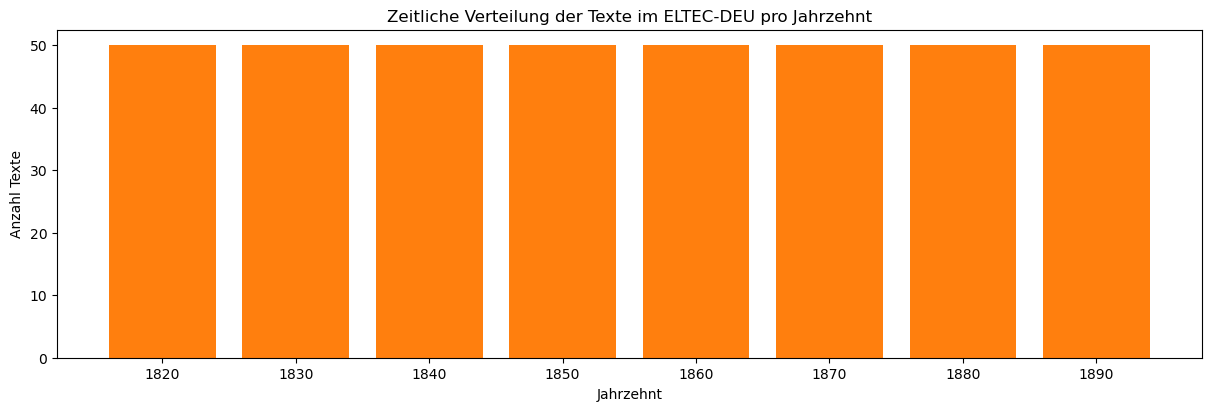

In [21]:
# Visualisierung der Dekadenverteilung (Textanzahl pro Dekade)
fig_decade, ax_decade = plt.subplots(figsize=(12, 4), constrained_layout=True)
ax_decade.bar(decade_counts.index.astype(str), decade_counts.values, color="tab:orange")
ax_decade.set_title("Zeitliche Verteilung der Texte im ELTEC-DEU pro Jahrzehnt")
ax_decade.set_xlabel("Jahrzehnt")
ax_decade.set_ylabel("Anzahl Texte")
plt.show()

In [22]:
subset_decades.to_csv('../metadata/metadata_corpus-german_language_fiction_1820-1900_50-per-decade.csv', index=False)

In [23]:
# pro Jahrzehnt 50 Texte zufällig ziehen -- no 2 (random state = 31415)
subset_decades_alt = (
    subset.groupby(subset['year']//10*10)
    .apply(lambda x: x.sample(n=min(50, len(x)), random_state=31415))
    .reset_index(drop=True)
)

In [26]:
subset_decades_alt.to_csv('../metadata/metadata_corpus-german_language_fiction_1820-1900_50-per-decade_ALT.csv', index=False)

## Reflexion: Auswahl als epistemische Entscheidung

Die Entscheidung für ein bestimmtes Korpus ist nie neutral.
Sie bestimmt, **welche literarischen Stimmen, Räume und historischen Kontexte** in der Analyse sichtbar werden.
Die bewusste Reflexion über diese Auswahl ist ein zentraler Bestandteil datenbasierter geisteswissenschaftlicher Forschung.

```{admonition} Merksatz
:class: keypoint
Mit der Auswahl eines Korpus konstruieren wir das epistemische Objekt unserer Forschung – und damit die Grenzen dessen, was wir erkennen können.
```